In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy

In [2]:
# df_dict = {}

# for i in ['review']: #,'business', 'checkin',  'tip', 'user']:
#     data = []
#     with open(f'yelp_academic_dataset_{i}.json', 'r') as file:
#         for line in file:
#             data.append(json.loads(line))

#     df = pd.DataFrame(data)
#     df_dict[f'df_{i}'] = df

FileNotFoundError: [Errno 2] No such file or directory: 'yelp/business.json'

In [3]:
df_review = pd.read_csv("yelp_academic_dataset_review.csv")
df_review = pd.DataFrame(df_review)

In [9]:
df_business = pd.read_csv("yelp_academic_dataset_business.csv")
df_business = pd.DataFrame(df_business)

In [10]:
df_user = pd.read_csv("yelp_academic_dataset_user.csv")
df_user = pd.DataFrame(df_user)

C:\Users\asus\AppData\Local\Temp\ipykernel_14948\1230748970.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_user = pd.read_csv("yelp_academic_dataset_user.csv")


In [45]:
# df_business = df_dict['df_business']
# df_user = df_dict['df_user']
# df_review = df_dict['df_review']

In [5]:
df_review

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


In [13]:
df_business=df_business[df_business['city']=='Philadelphia']
df_business = df_business[df_business["categories"].str.contains('Restaurants', na=False)]

# Filtrar as avaliações para apenas aquelas cujo 'business_id' está presente no df_business
df_merged = df_review[df_review['business_id'].isin(df_business['business_id'])]


In [12]:
#antes
# print(f'Number of users: {df_review["user_id"].nunique()}')
# print(f'Number of businesses: {df_review["business_id"].nunique()}')

Number of users: 1987929
Number of businesses: 150346


In [14]:
#depois de selecionar apenas reviews de restaurantes em philadelphia
print(f'Number of users: {df_merged["user_id"].nunique()}')
print(f'Number of businesses: {df_merged["business_id"].nunique()}')

Number of users: 209513
Number of businesses: 5852


In [28]:
# Too big to be in matrix format (~300B cells)
df_pivot = df_merged.pivot_table(index='user_id', columns='business_id', values='stars', aggfunc='mean')

In [55]:
df_pivot.head(2)

business_id,-0M0b-XhtFagyLmsBtOe8w,-0PN_KFPtbnLQZEeb23XiA,-0TffRSXXIlBYVbb5AwfTg,-0eUa8TsXFFy0FCxHYmrjg,-1B9pP_CrRBJYPICE5WbRA,-1b2kNOowsPrPpBOK4lNkQ,-2-ih3mE8KPyeKVIzpBfPQ,-32hOCwsuKd04WO-HQyYFg,-3ArWZfDjfab8qVHf3WVtg,-3m_nXlyvdKAVNNmVirpGQ,...,zwTmOj4B_OVPMTMYijQiKg,zwWgOoaLY-RnFgNVuMc7GA,zwd4dyQ5ovnjVojWfAuhMw,zwgBxmrmPBF6N2uRTUYXrQ,zxRmQ_FWVowh8rlzLCSURQ,zxY4DgtXsVHihSUpsmwamg,zy7uNOvpykrq-XlmDY_wHA,zyMkbavgHASQtqVwaock9A,zz-fcqurtm77bZ_rVvo2Lw,zzyx5x0Z7xXWWvWnZFuxlQ
user_id,,,,,,,,,,,,,,,,,,,,,
---r61b7EpVPkb4UVme5tA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--0kuuLmuYBe3Rmu0Iycww,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# df_limited = df_review[df_review['user_id'].isin(df_review['user_id'].unique()[:1000]) &
#                     df_review['business_id'].isin(df_review['business_id'].unique()[:1000])]
# df_limited.reset_index(drop=True, inplace=True)
# df_limited

df_limited = df_merged[df_merged['user_id'].isin(df_merged['user_id'].unique()[:5000]) &
                    df_merged['business_id'].isin(df_merged['business_id'].unique()[:100000])]
df_limited.reset_index(drop=True, inplace=True)
# df_limited

#THIS ENDS NOT BEING USED
# top_users = df_merged['user_id'].value_counts().nlargest(1000).index  # Top  users by review count
# top_businesses = df_merged['business_id'].value_counts().nlargest(1000).index  # Top businesses by review count

# # Step 2: Filter the pivot table for only the top users and businesses
# df_limited3 = df_merged[df_merged.index.isin(top_users)]  # Filter rows (users) based on the top users
# df_limited3 = df_limited3[df_limited3.index.isin(top_users)]  # Filter rows (users) based on the top users

# # df_limited3 = df_limited3.loc[:, df_limited3.columns.isin(top_businesses)]  # Filter columns (businesses) based on top businesses

# df_limited3.reset_index(drop=True, inplace=True)

# print(df_limited3.shape)



In [92]:
# Creating dataset from the df_review
reader = Reader(rating_scale=(df_limited.stars.min(), df_limited.stars.max()))
data = Dataset.load_from_df(df_limited[['user_id', 'business_id', 'stars']], reader)

# Train/test split
trainset, testset = train_test_split(data, test_size=0.2)

In [56]:
# # Creating dataset from the df_review
# reader = Reader(rating_scale=(df_merged.stars.min(), df_merged.stars.max()))
# data = Dataset.load_from_df(df_merged[['user_id', 'business_id', 'stars']], reader)

# # Train/test split
# trainset, testset = train_test_split(data, test_size=0.2)

In [86]:
df_merged.shape

(687289, 9)

In [87]:
# # Define evaluation function
# def evaluate_algorithm(algo, trainset, testset):
#     algo.fit(trainset)
#     predictions = algo.test(testset)
    
#     # Compute and return RMSE
#     rmse = accuracy.rmse(predictions)
#     return rmse

In [100]:
def evaluate_precision_recall(predictions, threshold=3.5):
    # Convert predictions to a binary format based on the threshold
    y_true = []
    y_pred = []

    # Count relevant items for precision and recall
    for uid, iid, true_r, est, _ in predictions:
        # Treat predictions >= threshold as relevant (1), otherwise not relevant (0)
        y_true.append(1 if true_r >= threshold else 0)
        y_pred.append(1 if est >= threshold else 0)

    # Calculate True Positives, False Positives, False Negatives
    true_positives = sum((1 for t, p in zip(y_true, y_pred) if t == 1 and p == 1))
    false_positives = sum((1 for t, p in zip(y_true, y_pred) if t == 0 and p == 1))
    false_negatives = sum((1 for t, p in zip(y_true, y_pred) if t == 1 and p == 0))

    # Calculate Precision and Recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

def evaluate_coverage(predictions, total_items): #I THINK THIS IS WRONG
    # Get the set of unique items recommended
    recommended_items = set(pred[1] for pred in predictions)  # pred[1] is the business_id
    coverage = len(recommended_items) / total_items if total_items > 0 else 0
    return coverage

In [104]:
def evaluate_algorithm(algo, trainset, testset, total_items):
    algo.fit(trainset)
    predictions = algo.test(testset)

    rmse = accuracy.rmse(predictions)

    precision, recall = evaluate_precision_recall(predictions)

    coverage = evaluate_coverage(predictions, total_items) #I THINK THIS IS WRONG

    return {
        "RMSE": rmse,
        "Precision": precision,
        "Recall": recall,
        "Coverage": coverage
    }

In [107]:
total_items = df_business['business_id'].nunique()  # Total number of unique businesses
random_algo = NormalPredictor()
evaluation_results = evaluate_algorithm(random_algo, trainset, testset, total_items)
print(evaluation_results)

# # Random Recommender
# random_algo = NormalPredictor()
# random_rmse = evaluate_algorithm(random_algo, trainset, testset)

RMSE: 1.4871
{'RMSE': 1.4871320786105455, 'Precision': 0.6695362183961533, 'Recall': 0.5964900158916603, 'Coverage': 0.6237183868762816}


In [125]:
algorithms = {
    "random": NormalPredictor(),
    "ubcf_msd": KNNBasic(sim_options={'user_based': True}),
    "ubcf_cosine": KNNBasic(sim_options={'user_based': True, 'name':"cosine"}),    
    "ibcf_msd": KNNBasic(sim_options={'user_based': False}),
    "ibcf_cosine": KNNBasic(sim_options={'user_based': False, 'name':"cosine"}),
    "svd_algo": SVD()
}

In [126]:
results = []

for name, algo in algorithms.items():
    metrics = evaluate_algorithm(algo, trainset, testset, total_items)
    metrics['Algorithm'] = name  # Add the algorithm name for reference
    results.append(metrics)

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display results
print(results_df)

RMSE: 1.4708
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0554
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0581
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0824
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0925
RMSE: 1.0017
       RMSE  Precision    Recall  Coverage    Algorithm
0  1.470758   0.678233  0.603676  0.623718       random
1  1.055436   0.729978  0.843916  0.623718     ubcf_msd
2  1.058088   0.727559  0.846749  0.623718  ubcf_cosine
3  1.082421   0.714845  0.858081  0.623718     ibcf_msd
4  1.092480   0.707316  0.848407  0.623718  ibcf_cosine
5  1.001680   0.753157  0.824086  0.623718     svd_algo


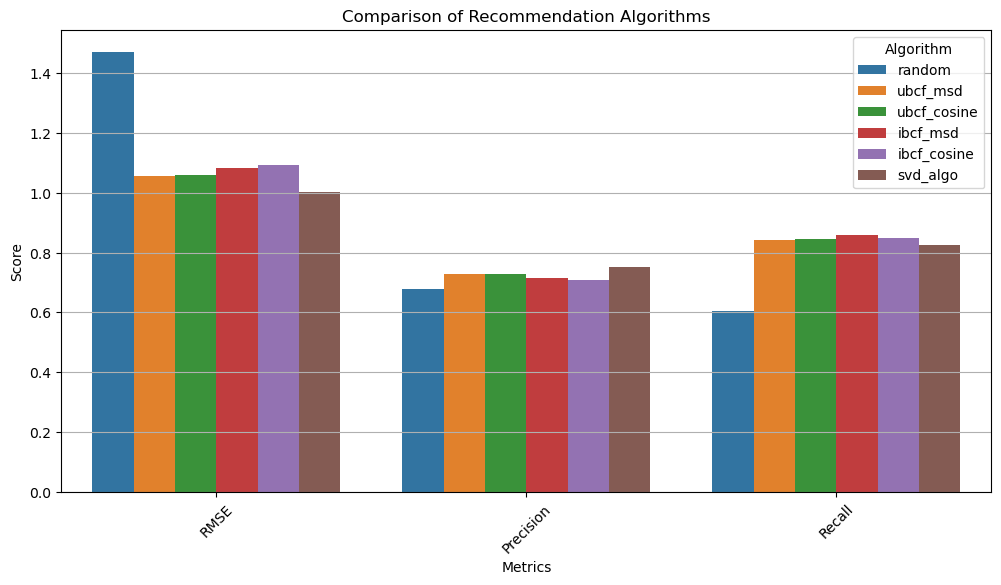

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

results_melted = results_df.melt(id_vars='Algorithm', value_vars=['RMSE', 'Precision', 'Recall'])#, 'Coverage'

plt.figure(figsize=(12, 6))
plt.grid()
sns.barplot(data=results_melted, x='variable', y='value', hue='Algorithm')
plt.title('Comparison of Recommendation Algorithms')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.xticks(rotation=45)
plt.legend(title='Algorithm')
plt.show()

In [129]:
from surprise import accuracy

# Function to get predictions for a model
def get_predictions(algo, testset):
    return algo.test(testset)

# Store predictions for each algorithm
predictions_dict = {}

for name, algo in algorithms.items():
    algo.fit(trainset)  # Train the algorithm
    predictions = get_predictions(algo, testset)
    predictions_dict[name] = predictions
import pandas as pd

# Prepare a DataFrame to store the actual and predicted ratings
comparison_data = []

for name, predictions in predictions_dict.items():
    for uid, iid, true_r, est, _ in predictions:
        comparison_data.append({
            "User ID": uid,
            "Business ID": iid,
            "True Rating": true_r,
            "Predicted Rating": est,
            "Model": name
        })

comparison_df = pd.DataFrame(comparison_data)
# Calculate RMSE for each model
results = {}

for name, predictions in predictions_dict.items():
    rmse = accuracy.rmse(predictions, verbose=False)
    results[name] = rmse

# Convert results to DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Model", "RMSE"])
print(results_df)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
         Model      RMSE
0       random  1.471819
1     ubcf_msd  1.055436
2  ubcf_cosine  1.058088
3     ibcf_msd  1.082421
4  ibcf_cosine  1.092480
5     svd_algo  1.001629


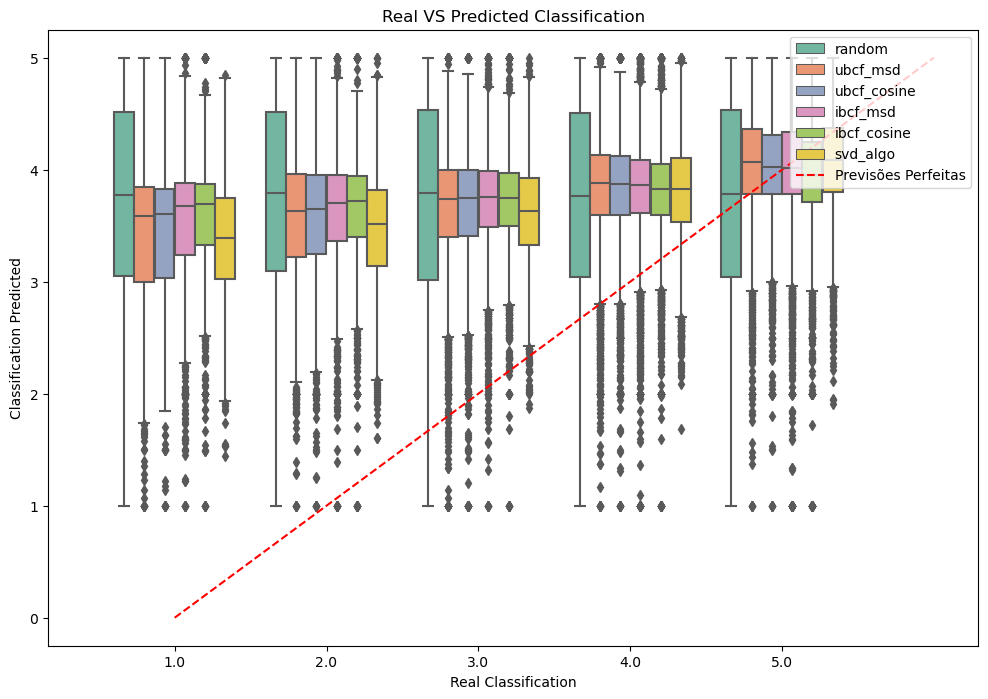

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crie o box plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=comparison_df, x='True Rating', y='Predicted Rating', hue='Model', palette='Set2')

# Adicionar linha de previsões perfeitas
plt.plot([0, 5], [0, 5], color='red', linestyle='--', label='Previsões Perfeitas')  # Linha para previsões perfeitas
plt.xlabel('Real Classification')
plt.ylabel('Classification Predicted')
plt.title('Real VS Predicted Classification')
plt.legend()
plt.show()



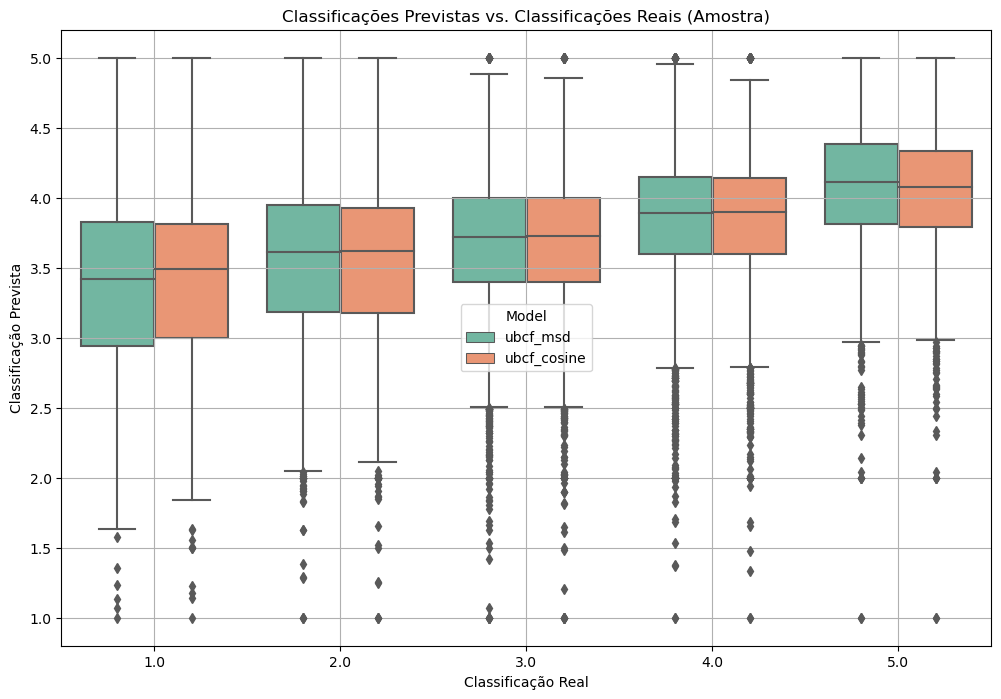

In [139]:
# plt.figure(figsize=(12, 8))
# sns.boxplot(data=sample_comparison_df, x='True Rating', y='Predicted Rating', hue='Model', palette='Set2')
# plt.xlabel('Real Classification')
# plt.ylabel('Classification Predicted')
# plt.title('Real VS PredictedClassification')
# plt.grid()
# plt.show()


In [94]:
# User-Based Collaborative Filtering
ubcf_algo = KNNBasic(sim_options={'user_based': True})
ubcf_rmse = evaluate_algorithm(ubcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0554


In [95]:
# Item-Based Collaborative Filtering
ibcf_algo = KNNBasic(sim_options={'user_based': False})
ibcf_rmse = evaluate_algorithm(ibcf_algo, trainset, testset)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 1.0824


In [96]:
# Singular Value Decomposition (SVD)
svd_algo = SVD()
svd_rmse = evaluate_algorithm(svd_algo, trainset, testset)

RMSE: 1.0019


In [97]:
print(f"Random RMSE: {random_rmse:.3f}")
print(f"User-Based CF RMSE: {ubcf_rmse:.3f}")
print(f"Item-Based CF RMSE: {ibcf_rmse:.3f}")
print(f"SVD RMSE: {svd_rmse:.3f}")

Random RMSE: 1.479
User-Based CF RMSE: 1.055
Item-Based CF RMSE: 1.082
SVD RMSE: 1.002


Adaptation of exercises from L02.1 (Lara)
### <a id='toc1_1_1_'></a>[Tokenization](#toc0_)
